<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for data manipulation

In this notebook we present the data manipulation functionalities from the `preprocess` module.

- [**Section 1**](#centering_and_scaling): Centering and scaling data sets
- [**Section 2**](#outlier_detection): Multivariate outlier detection from data sets
- [**Section 3**](#kernel_density): Kernel density weighting of data sets

***

**Should plots be saved?**

In [1]:
save_plots = False

***

In [2]:
from PCAfold import preprocess
from PCAfold import PreProcessing
from PCAfold import KernelDensity
from PCAfold import PCA
from PCAfold import reduction
import numpy as np

save_filename = None

***
<a id='centering_and_scaling'></a>
## Centering and scaling and constant variable removal

[**↑ Go to the top**](#top-page)

We begin by generating a dummy data set:

In [3]:
X = np.random.rand(100,20)

Centering and scaling can be performed in the following way:

In [4]:
(X_cs, X_center, X_scale) = preprocess.center_scale(X, 'range', nocenter=False)

Uncentering and unscaling can be performed in the following way to get back the original data set:

In [5]:
X = preprocess.invert_center_scale(X_cs, X_center, X_scale)

If constant variables are present in the data set, they can be removed using `preprocess.remove_constant_vars` function which can be a useful pre-processing before PCA is applied on a data set. Below we inject an artificial constant column to the dummy data set:

In [6]:
X[:,5] = np.ones((100,))

it can be removed by:

In [7]:
(X_removed, idx_removed, idx_retained) = preprocess.remove_constant_vars(X)

Indices of any removed columns are stored in the `idx_removed` vector:

In [8]:
idx_removed

[5]

In addition to that, an object of the `PreProcessing` class can be created and used to store the combination of the above pre-processing:

In [9]:
preprocessed = preprocess.PreProcessing(X, 'range', nocenter=False)

Centered and scaled data set can then be accessed as class attribute:

In [10]:
preprocessed.X_cs

array([[-1.44440086e-01,  1.96948637e-01, -4.84582156e-01, ...,
         1.13068259e-01, -1.03703772e-01,  4.63140643e-01],
       [-3.72419461e-01, -4.05027375e-01, -1.13995108e-04, ...,
         2.77896388e-02,  3.87907981e-01,  1.73664103e-02],
       [ 1.91132709e-02,  4.91919277e-01,  4.94049781e-01, ...,
        -2.83293730e-01,  1.65114686e-01, -3.94172320e-01],
       ...,
       [-4.98900027e-02, -1.31427413e-01,  4.11263465e-01, ...,
        -1.50395404e-01, -2.38483835e-01, -4.43363932e-02],
       [ 3.06620665e-01, -1.29602790e-01, -2.76570254e-01, ...,
         1.22891453e-02,  3.10165029e-01, -4.69981430e-01],
       [ 3.56914007e-01,  2.30885451e-01, -3.10762292e-01, ...,
         3.58479299e-01,  3.66122191e-01, -1.62629872e-01]])

as well as the corresponding centers and scales:

In [11]:
preprocessed.X_center

array([0.52388359, 0.4884227 , 0.49059751, 0.50876498, 0.44912421,
       0.47840158, 0.50321546, 0.46445985, 0.50980543, 0.51013086,
       0.53204859, 0.48493768, 0.49427051, 0.51022923, 0.51884926,
       0.48378487, 0.44913567, 0.48249253, 0.5011555 ])

In [12]:
preprocessed.X_scale

array([0.98933004, 0.95684545, 0.99294269, 0.9962432 , 0.97227756,
       0.98158522, 0.97104225, 0.9578658 , 0.96000849, 0.99154719,
       0.9897744 , 0.98156686, 0.96658567, 0.99240122, 0.97715356,
       0.95891158, 0.96400536, 0.9890461 , 0.99682935])

***
<a id='outlier_detection'></a>
## Multivariate outlier detection

[**↑ Go to the top**](#top-page)

Genrate a two-dimensional data set with artificial outliers:

In [13]:
N = 2000
mean = [3, 3]
covariance = [[1, 0.2], [0.2, 1]]
x_data, y_data = np.random.multivariate_normal(mean, covariance, N).T

N_outliers = 20
mean_outliers = [7, 10]
covariance_outliers = [[0.2, .1], [.1, 0.2]]
x_outliers, y_outliers = np.random.multivariate_normal(mean_outliers, covariance_outliers, N_outliers).T

idx = np.zeros((N+N_outliers,))
x = np.vstack((x_data[:,np.newaxis], x_outliers[:,np.newaxis]))
y = np.vstack((y_data[:,np.newaxis], y_outliers[:,np.newaxis]))
X = np.hstack((x, y))

(n_observations, n_variables) = np.shape(X)

Visualize the data set and outliers using the `preprocess.plot_2d_clustering` function. Cluster `"0"` will be the data set and cluster `"1"` will be the outliers:

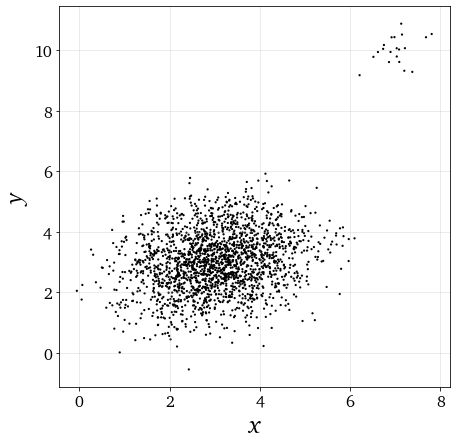

In [14]:
if save_plots: save_filename = '../images/data-manipulation-initial-data.svg'
plt = reduction.plot_2d_manifold(x, y, color='k', x_label='$x$', y_label='$y$', colorbar_label=None, title=None, save_filename=save_filename)

### Find multivariate outliers using `MULTIVARIATE TRIMMING` option

In [15]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='MULTIVARIATE TRIMMING', trimming_threshold=0.6, verbose=True)

Number of observations classified as outliers: 20


We are going to visualize how the algorithm classified the data into outliers/not-outliers. We begin by generating the new cluster classification vector, where the cluster $k_0$ will be non-outliers and cluster $k_1$ will be outliers:

In [16]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1
        
idx_new = idx_new.astype(int)

We can plot the partitioning:

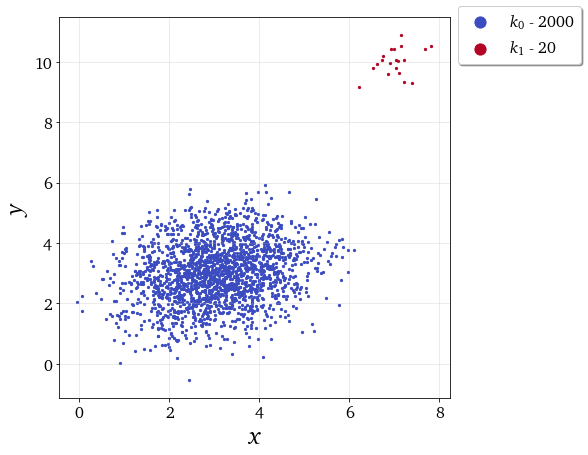

In [17]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-60.svg'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

If the parameter `trimming_threshold` is decreased, we more points that are within the data cloud become classified as outliers:

In [18]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='MULTIVARIATE TRIMMING', trimming_threshold=0.3, verbose=True)

Number of observations classified as outliers: 161


In [19]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1
        
idx_new = idx_new.astype(int)

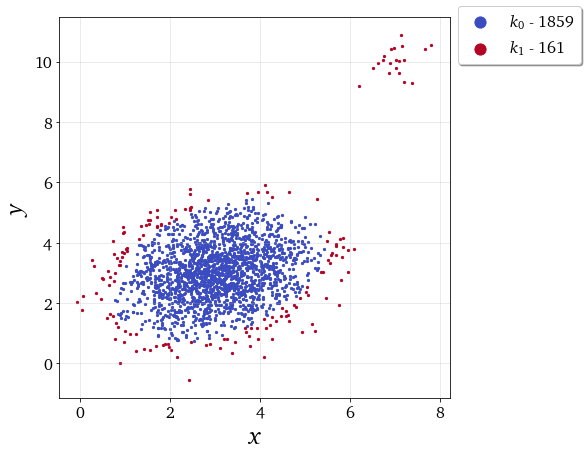

In [20]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-30.svg'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

### Find multivariate outliers using `PC CLASSIFIER` option

In [21]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='PC CLASSIFIER', quantile_threshold=0.9899, verbose=True)

Major components that will be selected are: 1
Minor components that will be selected are: 2
Number of observations classified as outliers: 42


In [22]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1
        
idx_new = idx_new.astype(int)

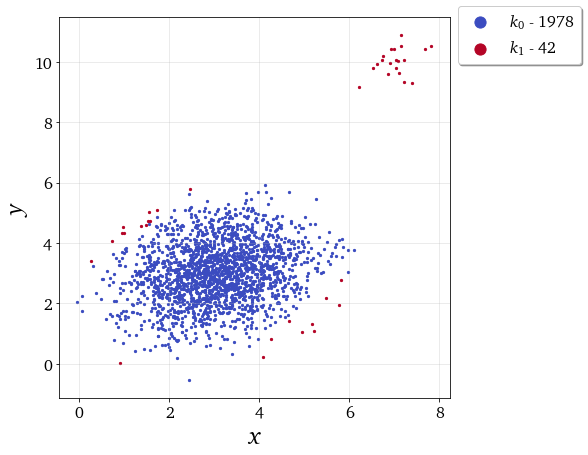

In [23]:
if save_plots: save_filename = '../images/data-manipulation-outliers-pc-classifier.svg'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

***
<a id='kernel_density'></a>
## Kernel density weighting

[**↑ Go to the top**](#top-page)

In this tutorial we reproduce results generated on a synthetic data set from the following paper:

> [Coussement, A., Gicquel, O., & Parente, A. (2012). Kernel density weighted principal component analysis of combustion processes. Combustion and flame, 159(9), 2844-2855.](https://www.sciencedirect.com/science/article/abs/pii/S001021801200123X)

We begin by generating a synthetic data set:

In [24]:
n_observations = 2021
x1 = np.zeros((n_observations,1))
x2 = np.zeros((n_observations,1))

for i in range(0,n_observations):
    
    R = np.random.rand()

    if i <= 999:
        
        x1[i] = -1 + 20*R
        x2[i] = 5*x1[i] + 100*R
 
    if i >= 1000 and i <= 1020:
        
        x1[i] = 420 + 8*(i+1 - 1001)
        x2[i] = 5000/200 * (x1[i] - 400) + 500*R

    if i >= 1021 and i <= 2020:
        
        x1[i] = 1000 + 20*R
        x2[i] = 5*x1[i] + 100*R

X = np.hstack((x1, x2))

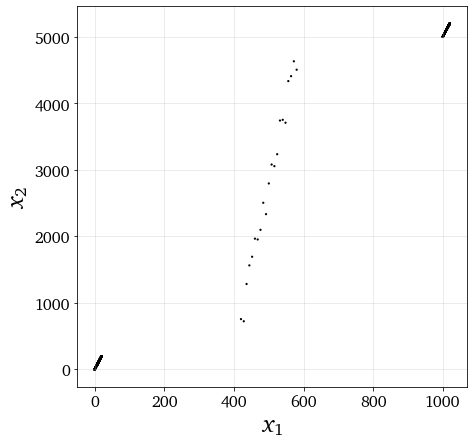

In [25]:
if save_plots: save_filename = '../images/kernel-density-original-data.svg'
plt = reduction.plot_2d_manifold(x1, x2, x_label='$x_1$', y_label='$x_2$', save_filename=save_filename)

We will also define a function that will create parity plots of the reconstructed data set:

### Reconstructing the data set without weighting

We will first demonstrate how the data set is reconstructed using only the first Principal Component obtained on the unweighted data set.

In [26]:
pca = PCA(X, scaling='auto', n_components=1)
PCs = pca.transform(X)
X_rec = pca.reconstruct(PCs)

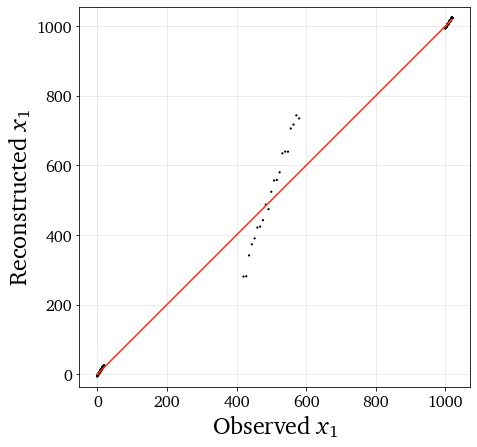

In [27]:
if save_plots: save_filename = '../images/kernel-density-original-x1.svg'
plt = reduction.plot_parity(X[:,0], X_rec[:,0], x_label='Observed $x_1$', y_label='Reconstructed $x_1$', save_filename=save_filename)

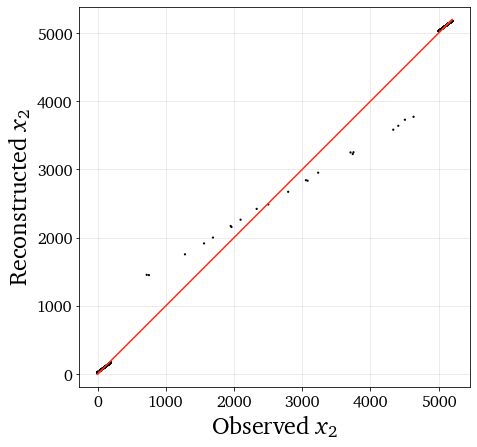

In [28]:
if save_plots: save_filename = '../images/kernel-density-original-x2.svg'
plt = reduction.plot_parity(X[:,1], X_rec[:,1], x_label='Observed $x_2$', y_label='Reconstructed $x_2$', save_filename=save_filename)

### Single-variable case

We first compute weights using a single variable as the conditioning variable:

In [29]:
%time kernd_single = KernelDensity(pca.X_cs, pca.X_cs[:,0], verbose=True)

Single-variable case will be applied.
CPU times: user 19.2 s, sys: 132 ms, total: 19.3 s
Wall time: 19.5 s


Obtain data set weighted by the computed weights:

In [30]:
X_weighted_single = kernd_single.X_weighted

Weights vector $\mathbf{W_c}$ can also be obtained as the class attribute:

In [31]:
single_weights = kernd_single.weights

Perform PCA on the weighted data set:

In [32]:
pca_single = PCA(X_weighted_single, 'none', n_components=1, nocenter=True)
PCs_single = pca_single.transform(pca.X_cs)
X_rec_single = pca_single.reconstruct(PCs_single)
X_rec_single = (X_rec_single * pca.X_scale) + pca.X_center

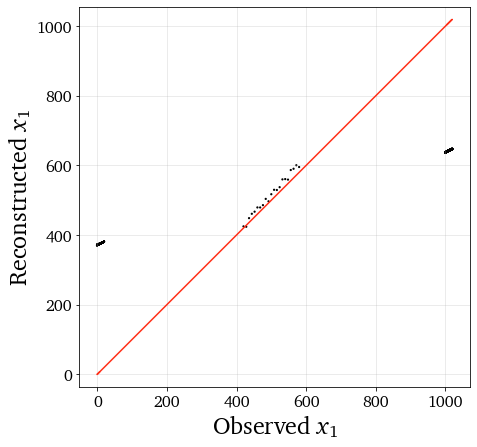

In [33]:
if save_plots: save_filename = '../images/kernel-density-single-x1.svg'
plt = reduction.plot_parity(X[:,0], X_rec_single[:,0], x_label='Observed $x_1$', y_label='Reconstructed $x_1$', save_filename=save_filename)

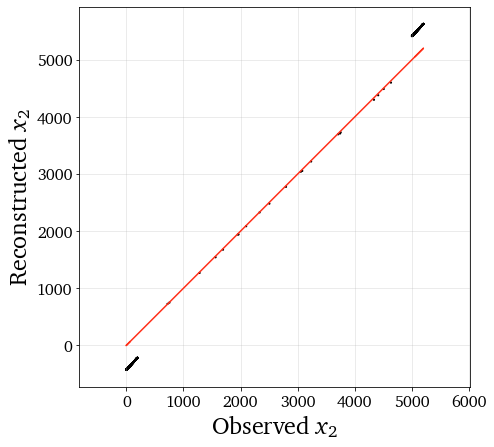

In [34]:
if save_plots: save_filename = '../images/kernel-density-single-x2.svg'
plt = reduction.plot_parity(X[:,1], X_rec_single[:,1], x_label='Observed $x_2$', y_label='Reconstructed $x_2$', save_filename=save_filename)

### Multi-variable case:

In [35]:
%time kernd_multi = KernelDensity(pca.X_cs, pca.X_cs, verbose=True)

Multi-variable case will be applied.
CPU times: user 38.5 s, sys: 286 ms, total: 38.8 s
Wall time: 39.2 s


Obtain data set weighted by the computed weights:

In [36]:
X_weighted_multi = kernd_multi.X_weighted

Weights vector $\mathbf{W_c}$ can also be obtained as the class attribute:

In [37]:
multi_weights = kernd_multi.weights

Perform PCA on the weighted data set:

In [38]:
pca_multi = PCA(X_weighted_multi, 'none', n_components=1)
PCs_multi = pca_multi.transform(pca.X_cs)
X_rec_multi = pca_multi.reconstruct(PCs_multi)
X_rec_multi = (X_rec_multi * pca.X_scale) + pca.X_center

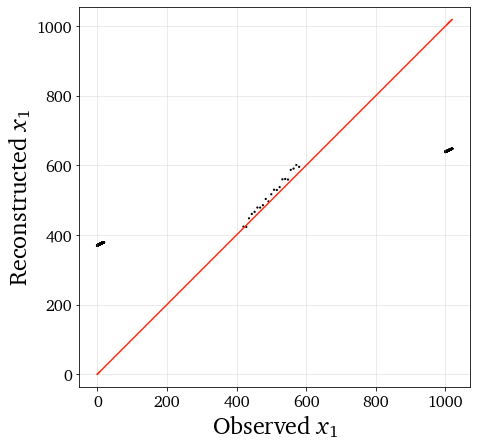

In [39]:
if save_plots: save_filename = '../images/kernel-density-multi-x1.svg'
plt = reduction.plot_parity(X[:,0], X_rec_multi[:,0], x_label='Observed $x_1$', y_label='Reconstructed $x_1$', save_filename=save_filename)

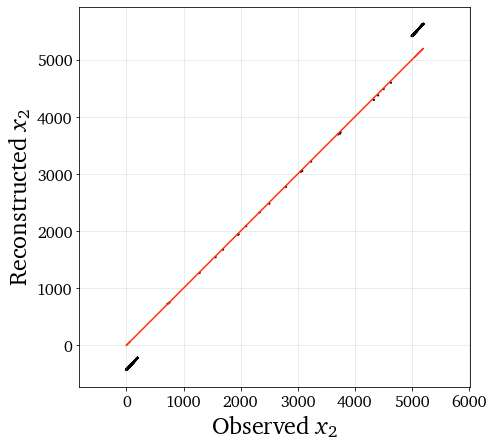

In [40]:
if save_plots: save_filename = '../images/kernel-density-multi-x2.svg'
plt = reduction.plot_parity(X[:,1], X_rec_multi[:,1], x_label='Observed $x_2$', y_label='Reconstructed $x_2$', save_filename=save_filename)

***